Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

- Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

- Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

- Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

- Задание 3: использовать permutation importance, выполнить задание 1 и 2.

- Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

- Задание 5: использовать shap, выполнить задание 1 и 2.

- Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mp
import lightgbm as lgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, recall_score, accuracy_score, auc, classification_report, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, \
                            plot_precision_recall_curve, roc_curve, plot_roc_curve)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from tqdm import tqdm

In [5]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 25 kB/s 


In [6]:
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_test.csv'

In [9]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_train.csv'

In [10]:
data = pd.read_csv(train_path)

In [11]:
test = pd.read_csv(test_path)

In [12]:
target = data["isFraud"]
data = data.drop(["isFraud"], axis=1)

numerical_features_train = data.select_dtypes(include=np.number)
categorical_features_train = data.select_dtypes(include=["object"])

In [13]:
numerical_features_test = test.select_dtypes(include=np.number)
categorical_features_test = test.select_dtypes(include=["object"])

In [14]:
# список признаков с категорией object на трейне
obj_list = categorical_features_train.columns.to_list()
obj_list, len(obj_list)

(['ProductCD',
  'card4',
  'card6',
  'P_emaildomain',
  'R_emaildomain',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9'],
 14)

In [15]:
# переведём пропуски в пустое значение и в строку (для теста и для трейна)
for feature in obj_list:
    data[feature] = categorical_features_train.fillna('')
    data[feature] = categorical_features_train[feature].astype('str')
    test[feature] = categorical_features_test.fillna('')
    test[feature] = categorical_features_test[feature].astype('str')

In [16]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=1,
)


x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=42
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=42
)

In [17]:
y_lead = test['isFraud']
x_lead = test.drop('isFraud', axis=1)

In [18]:
train_pool = cb.Pool(x_train, y_train, cat_features=obj_list)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=obj_list)

In [19]:
cb_params = {
    "n_estimators": 1400,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 35,
    "thread_count": -1,
    "random_seed": 25
}

In [20]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6381289	best: 0.6381289 (0)	total: 652ms	remaining: 15m 12s
50:	test: 0.8500685	best: 0.8501336 (47)	total: 30s	remaining: 13m 12s
100:	test: 0.8620131	best: 0.8620131 (100)	total: 1m	remaining: 12m 57s
150:	test: 0.8685046	best: 0.8685046 (150)	total: 1m 30s	remaining: 12m 31s
200:	test: 0.8758660	best: 0.8758671 (199)	total: 2m 2s	remaining: 12m 13s
250:	test: 0.8822371	best: 0.8822371 (250)	total: 2m 33s	remaining: 11m 41s
300:	test: 0.8849140	best: 0.8849140 (300)	total: 3m 3s	remaining: 11m 9s
350:	test: 0.8876846	best: 0.8876846 (350)	total: 3m 33s	remaining: 10m 37s
400:	test: 0.8890385	best: 0.8890388 (399)	total: 4m 2s	remaining: 10m 3s
450:	test: 0.8902269	best: 0.8902269 (450)	total: 4m 31s	remaining: 9m 31s
500:	test: 0.8907953	best: 0.8908266 (491)	total: 5m 1s	remaining: 9m
550:	test: 0.8912281	best: 0.8912315 (549)	total: 5m 30s	remaining: 8m 29s
600:	test: 0.8918291	best: 0.8918291 (600)	total: 6m	remaining: 7m 59s
650:	test: 0.8921536	best: 0.8921618 (617)	t

In [21]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_cb.predict_proba(x_train)[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_test, model_cb.predict_proba(x_test)[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_valid, model_cb.predict_proba(x_valid)[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_cb.predict_proba(x_lead)[:, 1]), 3)}")

ROC AUC train = 0.905
ROC AUC valid = 0.9
ROC AUC test = 0.892
ROC AUC leaderboard = 0.861


## Задание 1. 

In [22]:
pd.DataFrame({'feature_importance': model_cb.get_feature_importance(train_pool), 
              'feature_names': data.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
28,5.982045,C13
29,5.468999,C14
48,4.288958,M4
26,3.297052,C11
370,3.144482,V317
...,...,...
182,0.000000,V129
181,0.000000,V128
179,0.000000,V126
176,0.000000,V123


In [23]:
def plot_feature_importance(importance, names, model_type):
    
    n_feats = 50 
    feature_importance = np.array(importance[:n_feats])
    feature_names = np.array(names[:n_feats])
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(20,15))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

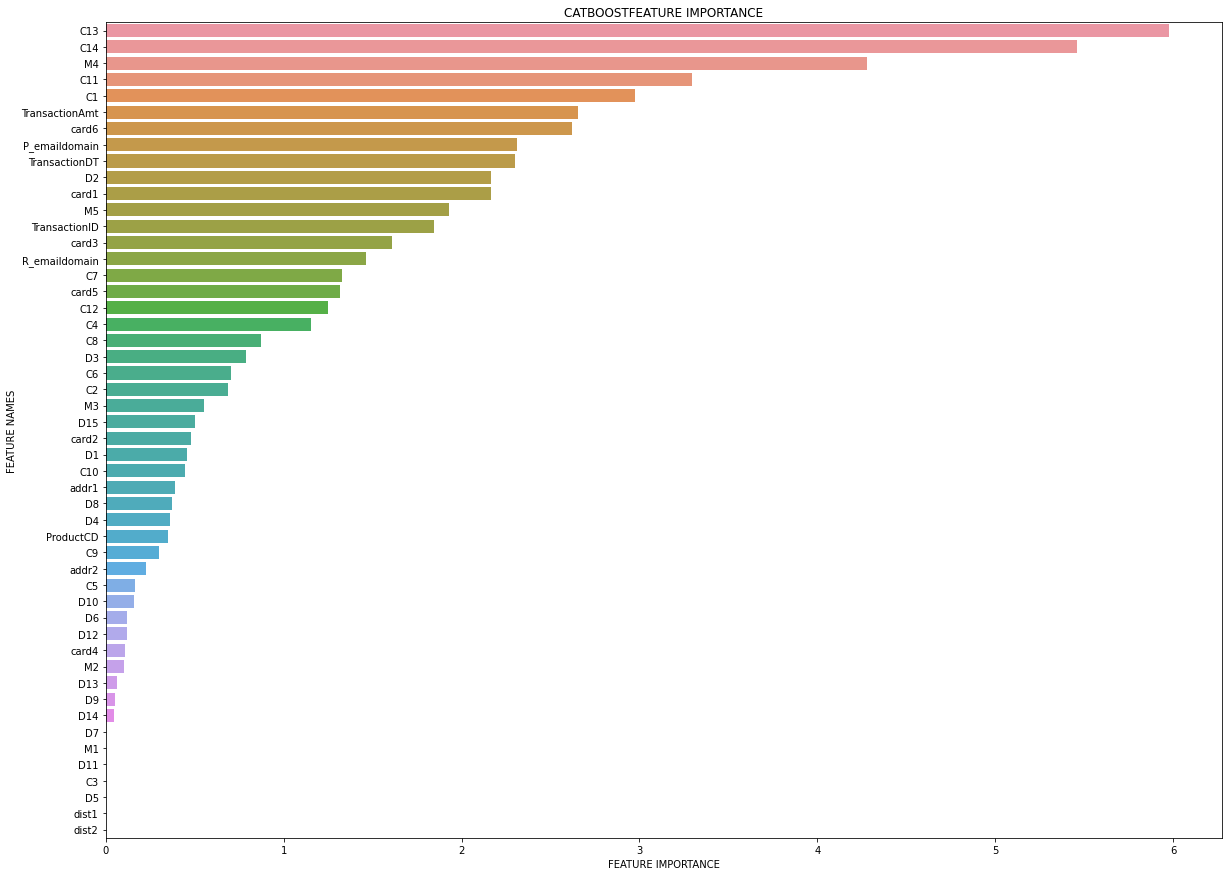

In [24]:
plot_feature_importance(model_cb.get_feature_importance(), data.columns, 'CATBOOST')

## Задание 2. 

In [25]:
importance_values = pd.DataFrame({'feature_importance': model_cb.get_feature_importance(train_pool), 
              'feature_names': data.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

In [26]:
importance_values.head()

,feature_importance,feature_names
28,5.982045,C13
29,5.468999,C14
48,4.288958,M4
26,3.297052,C11
370,3.144482,V317


In [27]:
features = importance_values.feature_names[:50].to_list()

In [28]:
cat_list=[]
for feat in features:
  if feat in set(obj_list):
    cat_list.append(feat)

In [29]:
cat_list

['M4', 'card6', 'P_emaildomain', 'M5', 'R_emaildomain', 'M3']

In [30]:
train_pool_2 = cb.Pool(x_train[features], y_train, cat_features=cat_list)
valid_pool_2 = cb.Pool(x_valid[features], y_valid, cat_features=cat_list)

In [31]:
cb_params = {
    "n_estimators": 1400,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 35,
    "thread_count": -1,
    "random_seed": 25
}

In [32]:
model_cb_2 = cb.CatBoostClassifier(**cb_params)
model_cb_2.fit(train_pool_2, eval_set=valid_pool_2, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6215897	best: 0.6215897 (0)	total: 276ms	remaining: 6m 26s
50:	test: 0.8529126	best: 0.8541523 (42)	total: 13.4s	remaining: 5m 54s
100:	test: 0.8624132	best: 0.8624132 (100)	total: 26.5s	remaining: 5m 41s
150:	test: 0.8720083	best: 0.8720083 (150)	total: 39.2s	remaining: 5m 24s
200:	test: 0.8795935	best: 0.8795935 (200)	total: 51.7s	remaining: 5m 8s
250:	test: 0.8840361	best: 0.8840361 (250)	total: 1m 4s	remaining: 4m 53s
300:	test: 0.8859951	best: 0.8859951 (300)	total: 1m 16s	remaining: 4m 38s
350:	test: 0.8883634	best: 0.8883634 (350)	total: 1m 28s	remaining: 4m 24s
400:	test: 0.8897688	best: 0.8897953 (399)	total: 1m 40s	remaining: 4m 10s
450:	test: 0.8899394	best: 0.8899395 (446)	total: 1m 51s	remaining: 3m 54s
500:	test: 0.8899401	best: 0.8899401 (498)	total: 1m 59s	remaining: 3m 34s
550:	test: 0.8899404	best: 0.8899404 (550)	total: 2m 7s	remaining: 3m 16s
600:	test: 0.8899410	best: 0.8899410 (592)	total: 2m 15s	remaining: 3m
650:	test: 0.8899414	best: 0.8899414 (645)	

In [33]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_cb_2.predict_proba(x_train[features])[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_test, model_cb_2.predict_proba(x_test[features])[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_valid, model_cb_2.predict_proba(x_valid[features])[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_cb_2.predict_proba(x_lead[features])[:, 1]), 3)}")

ROC AUC train = 0.905
ROC AUC valid = 0.899
ROC AUC test = 0.89
ROC AUC leaderboard = 0.856


In [34]:
#Task 1
#ROC AUC train = 0.905
#ROC AUC valid = 0.9
#ROC AUC test = 0.892
#ROC AUC leaderboard = 0.861

#Task 2
#ROC AUC train = 0.905
#ROC AUC valid = 0.899
#ROC AUC test = 0.89
#ROC AUC leaderboard = 0.856

# Вывод: качество на лидерборде чуть-чуть ухудшилось. 

## Задание 3. 

In [35]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [36]:
scores, importance = calculate_permutation_importance(
    model_cb, roc_auc_score, x_valid, y_valid
)

100%|██████████| 393/393 [02:12<00:00,  2.97it/s]


In [37]:
#важность фичей permutation importance
importance

C13     0.012831
C14     0.009889
C1      0.008637
M4      0.006078
C11     0.005598
          ...   
C7     -0.000294
V282   -0.000421
V243   -0.000516
D2     -0.000550
V188   -0.000552
Length: 393, dtype: float64

## Улучшим модель на основе permutation importance

In [38]:
to_drop = importance[importance<=0].index.tolist()

In [39]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=11,
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=11,
)


x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=22
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=22
)

In [40]:
y_lead = test['isFraud']
x_lead = test.drop('isFraud', axis=1)

In [41]:
obj_list

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [42]:
cat_list_3 = []
for feat in obj_list: 
  if feat in set(to_drop):
    cat_list_3.append(feat)

In [43]:
cat_list_3

['M1', 'M7', 'M8', 'M9']

In [44]:
spam = set(obj_list) - set(cat_list_3)

In [45]:
spam = list(spam)

In [46]:
train_pool_3 = cb.Pool(x_train.drop(to_drop, axis=1), y_train, cat_features=spam)
valid_pool_3 = cb.Pool(x_valid.drop(to_drop, axis=1), y_valid, cat_features=spam)

In [47]:
model_cb_3 = cb.CatBoostClassifier(**cb_params)
model_cb_3.fit(train_pool_3, eval_set=valid_pool_3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6276289	best: 0.6276289 (0)	total: 319ms	remaining: 7m 26s
50:	test: 0.8389168	best: 0.8394566 (49)	total: 21s	remaining: 9m 16s
100:	test: 0.8569513	best: 0.8569513 (100)	total: 42s	remaining: 9m
150:	test: 0.8650691	best: 0.8650691 (150)	total: 1m 2s	remaining: 8m 40s
200:	test: 0.8716754	best: 0.8716754 (200)	total: 1m 24s	remaining: 8m 21s
250:	test: 0.8764975	best: 0.8764975 (250)	total: 1m 45s	remaining: 8m 2s
300:	test: 0.8820367	best: 0.8820367 (300)	total: 2m 6s	remaining: 7m 41s
350:	test: 0.8839874	best: 0.8839880 (349)	total: 2m 26s	remaining: 7m 16s
400:	test: 0.8862351	best: 0.8862568 (399)	total: 2m 46s	remaining: 6m 55s
450:	test: 0.8875884	best: 0.8875885 (449)	total: 3m 7s	remaining: 6m 34s
500:	test: 0.8888487	best: 0.8888487 (500)	total: 3m 27s	remaining: 6m 12s
550:	test: 0.8903277	best: 0.8903277 (550)	total: 3m 48s	remaining: 5m 51s
600:	test: 0.8915346	best: 0.8915346 (600)	total: 4m 9s	remaining: 5m 31s
650:	test: 0.8933079	best: 0.8933079 (650)	tota

In [48]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_cb_3.predict_proba(x_train.drop(to_drop, axis=1))[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_test, model_cb_3.predict_proba(x_test.drop(to_drop, axis=1))[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_valid, model_cb_3.predict_proba(x_valid.drop(to_drop, axis=1))[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_cb_3.predict_proba(x_lead.drop(to_drop, axis=1))[:, 1]), 3)}")

ROC AUC train = 0.914
ROC AUC valid = 0.914
ROC AUC test = 0.9
ROC AUC leaderboard = 0.866


In [49]:
#Task 1
#ROC AUC train = 0.905
#ROC AUC valid = 0.9
#ROC AUC test = 0.892
#ROC AUC leaderboard = 0.861

#Task 2
#ROC AUC train = 0.905
#ROC AUC valid = 0.899
#ROC AUC test = 0.89
#ROC AUC leaderboard = 0.856

#Task 3
#ROC AUC train = 0.914
#ROC AUC valid = 0.914
#ROC AUC test = 0.9
#ROC AUC leaderboard = 0.866

# Вывод: качество на лидерборде улучшилось на 0.005

In [50]:
#Задание 4, 5, 6 в другом файле. 